# Exercises

Discrete Data + Probability

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.


In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns


# Acquire

In [2]:
# create list of column names to use for dataframe
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

# read the csv, there is a lot of exceptions/narly data to parse
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

# this creates some new data that is not in the original csv
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

# this appends the new data with what the csv brings in 
df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


# Prepare

In [4]:
# first clean up the timestamp column so it is recognized as a timestamp
# remove the brackets
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
# replace the : with a space
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
# set the timestamp as the index for time series analysis(TSA)
df = df.set_index('timestamp')

In [5]:
# cleanup the text
# get rid of the quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
# remove the page #
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
# add a feature that converts size in bytes to MB
df['size_mb'] = [n/1024/1024 for n in df['size']]

# Look for anomalies in IP address

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  int64  
 3   size            13978 non-null  int64  
 4   destination     25 non-null     object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.6+ KB


In [8]:
df.ip.count()

13978

In [9]:
# first create a dataframe of the unique values in the IP address column and
# the count of the occurances of that address
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
# now create dataframe of probability of that ip appearing in the dataset
# probability is the count of occurances of that ip address in the data divided by the total occurances(rows)
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [10]:
ip_df.head()

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [11]:
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502


In [12]:
# merge these two dataframes together
ip_df = ip_df.merge(ip_df2)

# see those where rate < 1% 
# look for the addresses that occur rarely, less than 1% of the time
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,52.87.230.102,2,0.000143
7,35.175.171.137,2,0.000143
8,70.121.214.34,2,0.000143
9,34.229.70.250,1,0.000072
10,3.92.201.136,1,0.000072
11,54.172.14.223,1,0.000072
12,52.90.165.200,1,0.000072
13,97.105.15.120,1,0.000072


22
               ip  ip_count  ip_proba
12  52.90.165.200         1  0.000072
13  97.105.15.120         1  0.000072
14   45.23.250.16         1  0.000072
15   3.88.129.158         1  0.000072
16   95.31.16.121         1  0.000072
17   35.174.209.2         1  0.000072
18   52.91.30.150         1  0.000072
19  34.207.64.242         1  0.000072
20   95.31.18.119         1  0.000072
21  54.145.52.184         1  0.000072


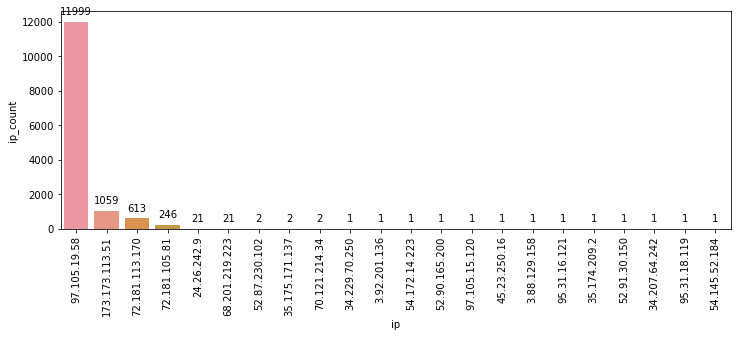

In [13]:
# this tells us there are 22 unique IP addresses
print(len(ip_df))

# this prints the last 10 rows in the dataframe
print(ip_df.tail(10))

# set the chart figure size
plt.figure(figsize=(12, 4))
# make a seaborn barplot, 'ci = None' means no bootstrapping/error bars will be drawn
# https://seaborn.pydata.org/generated/seaborn.barplot.html
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)

# this rotates the x labels, and puts the total # of occurances for each IP address at the top of that column 
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives.

In [14]:
pd.__version__

'1.1.3'

In [17]:
# establish a baseline
# create a train dataset that is from specific date range, specify columns in dataframe
#train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]
# this produces a werid numpy but

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
# this code from Adam works

In [18]:
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
